# Frequency correlation plots for natural populations from tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [51]:
import altair as alt
import Bio.Phylo
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [52]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [92]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["observed"] > freq_df["initial"])
        predicted_growth = (freq_df["estimated"] > freq_df["initial"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["observed"] <= freq_df["initial"])
        predicted_decline = (freq_df["estimated"] <= freq_df["initial"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [54]:
data_root = "../results/builds/natural/natural_sample_1_with_10_vpm/"

In [55]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [56]:
tips.head(1)

,strain,timepoint,frequency
0,A/England/121/1995,1995-10-01,0.003272


In [57]:
tree = Bio.Phylo.read("%s/final_tree.nwk" % data_root, "newick")

In [58]:
tree

Tree(rooted=False, weight=1.0)

In [59]:
forecasts = pd.read_csv(
    "%s/natural_sample_1_with_10_vpm_lbi_forecast.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "fitness", "frequency", "projected_frequency"]
)

In [60]:
forecasts.head(1)

,timepoint,strain,frequency,fitness,projected_frequency
0,1995-10-01,A/England/121/1995,0.003272,-2.645588,0.000436


## Find clade frequencies

Find frequencies of clades at all timepoints using only clades with extant tips at each timepoint. The approach would is:

1. Get tip attributes from censored builds
2. Get forecast tip frequencies from censored builds
3. Get final tree
4. For each timepoint in the censored builds, find all internal nodes in the tree with extant tips at the timepoint
5. For each internal node, calculate the initial frequency of tips at the current timepoint, the observed final frequency of tips at the next timepoint, and the estimated final frequency of tips and log the result.


In [67]:
timepoints = tips["timepoint"].unique()

In [69]:
timepoints[:5]

array(['1995-10-01T00:00:00.000000000', '1996-04-01T00:00:00.000000000',
       '1996-10-01T00:00:00.000000000', '1997-04-01T00:00:00.000000000',
       '1997-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [70]:
tips.head()

,strain,timepoint,frequency
0,A/England/121/1995,1995-10-01,0.003272
1,A/England/255/1995,1995-10-01,0.005768
2,A/England/258/1995,1995-10-01,0.044474
3,A/England/263/1995,1995-10-01,0.053012
4,A/England/268/1995,1995-10-01,0.069978


In [76]:
tips_by_node = {}
for node in tree.find_clades(terminal=False):
    tips_by_node[node.name] = set([tip.name for tip in node.find_clades(terminal=True)])

In [77]:
len(tips_by_node)

3278

In [106]:
timepoints[14]

numpy.datetime64('2002-10-01T00:00:00.000000000')

In [166]:
subset_timepoints = timepoints[-10:]

In [167]:
min_freq = 0.15

clade_frequencies = []
for i, timepoint in enumerate(subset_timepoints[:-2]):
    print("Timepoint: ", timepoint)
    tips_at_timepoint = tips[tips["timepoint"] == timepoint]
    tips_at_future_timepoint = tips[tips["timepoint"] == subset_timepoints[i + 2]]
    forecast_tips_at_timepoint = forecasts[forecasts["timepoint"] == timepoint]
    
    for total_nodes, node in enumerate(tree.find_clades(terminal=False)):            
        node_tips = tips_by_node[node.name]
        initial_freq = tips_at_timepoint.loc[tips_at_timepoint["strain"].isin(node_tips), "frequency"].sum()
        
        if initial_freq > min_freq:
            observed_freq = tips_at_future_timepoint.loc[tips_at_future_timepoint["strain"].isin(node_tips), "frequency"].sum()
            estimated_freq = forecast_tips_at_timepoint.loc[forecast_tips_at_timepoint["strain"].isin(node_tips), "projected_frequency"].sum()
            
            clade_frequencies.append({
                "initial": initial_freq,
                "observed": observed_freq,
                "estimated": estimated_freq
            })

Timepoint:  2011-04-01T00:00:00.000000000
Timepoint:  2011-10-01T00:00:00.000000000
Timepoint:  2012-04-01T00:00:00.000000000
Timepoint:  2012-10-01T00:00:00.000000000
Timepoint:  2013-04-01T00:00:00.000000000
Timepoint:  2013-10-01T00:00:00.000000000
Timepoint:  2014-04-01T00:00:00.000000000
Timepoint:  2014-10-01T00:00:00.000000000


In [168]:
len(clade_frequencies)

1282

In [169]:
clade_frequencies = pd.DataFrame(clade_frequencies)

In [170]:
clade_frequencies["observed_growth_rate"] = (
    clade_frequencies["observed"] / clade_frequencies["initial"]
)

In [171]:
clade_frequencies["estimated_growth_rate"] = (
    clade_frequencies["estimated"] / clade_frequencies["initial"]
)

In [172]:
clade_frequencies.head()

,estimated,initial,observed,observed_growth_rate,estimated_growth_rate
0,1.0,1.000003,0.999996,0.999993,0.999997
1,1.0,1.000003,0.999996,0.999993,0.999997
2,1.0,1.000003,0.999996,0.999993,0.999997
3,1.0,1.000003,0.999996,0.999993,0.999997
4,1.0,1.000003,0.999996,0.999993,0.999997


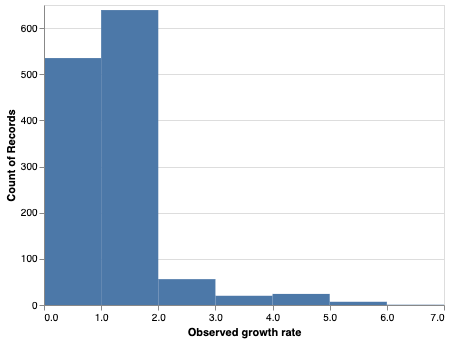

In [173]:
alt.Chart(clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the LBI model as an example, first.

In [174]:
clade_frequencies.shape

(1282, 5)

In [175]:
r, p = pearsonr(
    clade_frequencies["observed_growth_rate"],
    clade_frequencies["estimated_growth_rate"]
)

In [176]:
r

-0.06322540267708207

In [177]:
p

0.023583698446759567

In [178]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(clade_frequencies, True)

In [179]:
mcc

0.42821672061437627

In [180]:
confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])

0.7064989517819706

In [181]:
confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])

0.7774390243902439

In [182]:
min_growth_rate = 0
max_growth_rate = clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

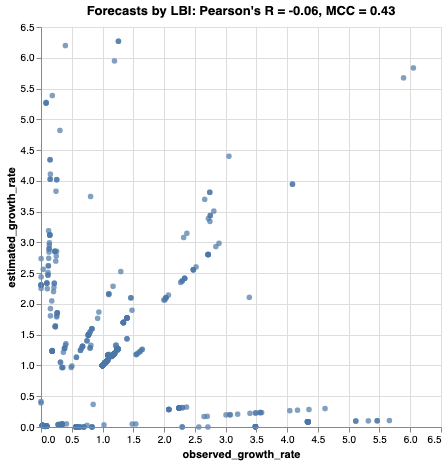

In [183]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "initial:Q", "observed:Q",
                      "estimated:Q", "clade_membership:N"]

chart = alt.Chart(clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

#chart.save("forecast_growth_correlation_natural_lbi.svg")
chart